<a href="https://colab.research.google.com/github/bcaffo/ds4bme_intro/blob/master/notebooks/notebook4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic regression
## Classification with one continuous variable

Suppose now that we want to predict the gold standard from the FLAIR values. Fitting a line seems weird, since the outcome can only be 0 or 1. A line would allow for arbitrarily small or large predictions. Similiarly, forcing the prediction to be exactly 0 or 1 leads to difficult optimization problems. A clever solution is to instead model

$$
P(Y_i = 1 ~|~ X_i)
$$

where $Y_i$ is the gold standard value (0 or 1 for no lesion or lesion at that voxel, respectively) and $X_i$ is the FLAIR value for voxel $i$. This solves the problem somewhat nicely, but it still leaves some issues unresolved. For example, what does probability even mean in this context? And also probabilities are between 0 and 1, that's better than exactly 0 or 1, but still would create problems.

For the probability, it's generally a good idea to think about what you're modeling as random in the context. In this case, we're thinking of our voxels as a random sample of FLAIR and gold standard voxel values from some population. This is a meaningful benchmark even if it's not true. We'll find that often in statistics we model data as if it comes from a probability distribution when we know it didn't. We simply know that the probability distribution is a useful model for thinking about the problem.

As for getting the probabilities from $[0,1]$ to $(-\infty, \infty)$, we need a function, preferably a monotonic one. The generally agreed upon choice is the logit (natural log of the odds) function. The logit function of a probability is defined as

$$
\eta = \mathrm{logit}(p) = \log\{p / (1 - p\}
$$

where $p$ is the probability and $O = p/(1-p)$ is called the **odds**. Note, you can go backwards from odds to probability with the function $p = O / (1 + O)$. Odds are exactly as used in gambling. If the odds of bet at 1 to 99, then you are saying the probability is $1 / (99 + 1) = 1\%$. 

You can go backwards from the logit function to the probability with the expit function. That is, if $\eta$ is defined as above, then
$$
p = \frac{e^{\eta}}{1 + e^\eta} = \frac{1}{1 + e^{-\eta}}.
$$
This is sometimes called the **expit** function or **sigmoid**.


We model the log of the odds as linear. This is called **logistic regression**.

$$
\eta = \mathrm{logit}\left\{ P(Y = 1 ~|~ X) \right\}
= \beta_0 + \beta_1 X.
$$

The nice part about this model is that $e^\beta_1$ has the nice interpretation of the odds ratio associated with a one unit change in $X$.

This is great, but we still need a function of the probabilities to optimize. We'll use the **cross entropy**. 
$$
-\sum_{i=1}^n \left[Y_i \log\{P(Y_i = 1 ~|~ X_i)\} + (1 - Y_i) \log\{1 - P(Y_i = 1 ~|~ X_i)\}\right].
$$
This function has the interpretation of being the negative of the log of the probabilities assuming the $Y_i$ are independent. This model doesn't have to hold for the minimization to be useful. 

Plugging our logit model in, the cross entropy now looks like
$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^\eta_i} \right\} \right].
$$
This is the function that we minimize to perform logistic regression. Later on, we'll worry about minimizing this function. However, today, let's fit logistic regression to some data.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
## this sets some style parameters
sns.set()

## Read in the data and display a few rows
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

/home/bcaffo/miniconda3/envs/ds4bio/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FLAIR', ylabel='GOLD_Lesions'>

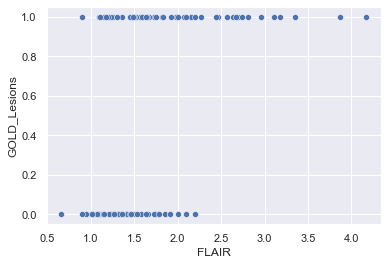

In [2]:
## Plot the data
sns.scatterplot('FLAIR', 'GOLD_Lesions', data = dat)


Let's now fit the model. Again we're going to split into training and test data. But, now we're not going to do it manually since we have to load a library that has a function to do this.

In [3]:
x = dat[['FLAIR']]
y = dat.GOLD_Lesions
trainFraction = .75

## Once again hold out some data
sample = np.random.uniform(size = 100) < trainFraction
xtrain = x[ sample]
ytrain = y[ sample]
xtest =  x[~sample]
ytest =  y[~sample]


In [4]:
lr = lm.LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(xtrain, ytrain)

Let's look at the parameters fit from the model

In [5]:
beta0, beta1 = [fit.intercept_[0], fit.coef_[0][0]]
[beta0, beta1]

[-3.3611395897397296, 2.009191393522844]

/home/bcaffo/miniconda3/envs/ds4bio/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/bcaffo/miniconda3/envs/ds4bio/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FLAIR', ylabel='GOLD_Lesions'>

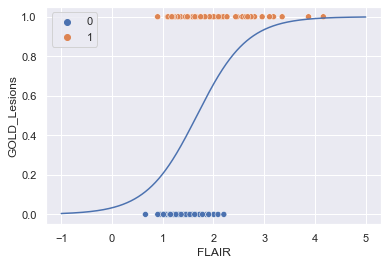

In [6]:
n = 1000
xplot = np.linspace(-1, 5, n)
eta = beta0 + beta1 * xplot
p = 1 / (1 + np.exp(-eta))

sns.scatterplot('FLAIR', 'GOLD_Lesions', data = dat, hue = 'GOLD_Lesions')
sns.lineplot(xplot, p)

## Of course, scikit has a predict
## function so that you don't have to do this manually
#yplot = fit.predict_proba(xplot.reshape((n, 1)))
#sns.lineplot(xplot, yplot[:, 1])


Now let's evaluate the test set.

In [7]:
## This predicts the classes using a 50% probability cutoff
yhat_test = fit.predict(xtest)

## double checking that if you want
#all(yhat_test == (fit.predict_proba(xtest)[:, 1] > .5))

accuracy = np.mean(yhat_test == ytest)
sensitivity = np.mean(yhat_test[ytest == 1] == ytest[ytest == 1])
specificity = np.mean(yhat_test[ytest == 0] == ytest[ytest == 0])
np.round([accuracy, sensitivity, specificity], 3)


array([0.704, 0.533, 0.917])

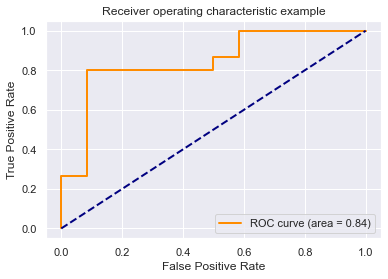

In [8]:
from sklearn.metrics import accuracy_score, roc_curve, auc

ptest = fit.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, ptest)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
